
# Practical Neighbourhood Connection to the Grid


#### Importing the needed packages
The first step in every python notebook is to install the needed packages (e.g. [`pandas`](https://pandas.pydata.org/docs/user_guide/index.html) for data management) as well as functions and classes from external scripts.

In [1]:
from illuminator.engine import Simulation
import functions_T1
import pandas as pd
import numpy as np

ModuleNotFoundError: No module named 'illuminator'

In this tutorial a neighbourhood is connected to the grid as sketched below. For a typical day in the year the neighbourhood has a given demand profile (load_data.txt file). The given load data is for a year and is given in 15 minute intervals. This electricity demand must be fulfilled.

#### Task 1: Load Profile for a Neighbourhood

In the first task entails the neighbourhood takes all electricity from the grid. The demand of the neighbourhood can be visualized in a load profile for a day of choice. The following python code plots a specified day based on the given load data and the specified number of houses in the neighbourhood. Electricity from the grid comes from various sources. The energy mix of the Netherlands can be found under https://www.iea.org/countries/the-netherlands/energy-mix. In the code the load data is first saved in a pandas dataframe and it is ensured that the index is the time. Then the day is chosen and a function is called to plot the load data on this day. 
<br> <br> Run the code and describe what you can see in the plot (certain regular peaks, irregularities, etc.). You can vary the day for which you want to plot the load with the day_of_year parameter. Here, you can also compare the load on different days.

![T1_basecase](Graphics_T1/neighbourhood_base_case_T1.png)

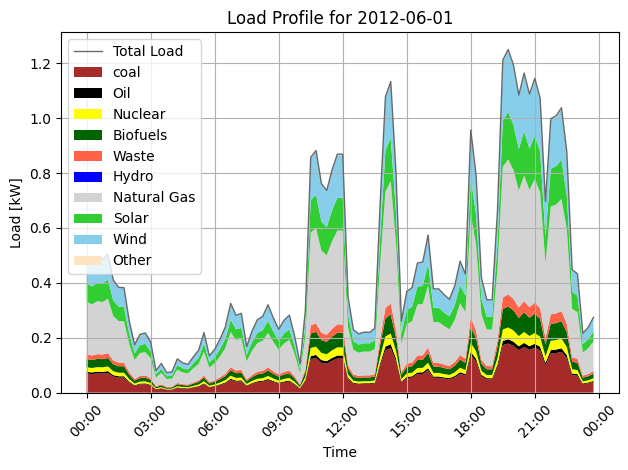

In [2]:
load_df = pd.read_csv('data/load_data.txt', delimiter=',', skiprows=1)
load_df['time'] = pd.to_datetime(load_df['time'])
load_df.set_index('time', inplace=True)
#choose which day of the year to plot
day_of_year = "2012-06-01"
number_houses = 5 
plot_load_base_case = functions_T1.plot_load_profile(load_df, day_of_year, number_houses)

The community implements small scale PV and wind power plants to become more autonomous. Now first the supply from the local renewable energy sources is used to cover the demand in the community. The residual load is then supplied by the grid. In case of excess renewable generation the generated electricity is fed into the grid.

![T1_RES_case](Graphics_T1/neighbourhood_RES_case_T1.png)

#### Task 2: Neighbourhood with local RES

In the below presented code the neighbourhood is set up by defining the key components (here Wind, PV and Load). After defining number of houses and specifications of the installed wind and solar energy in the neighbourhood, a simulation is created and started with the simulation_creator_Balancing class. Finally, the summarise_results function creates a plot and an hourly table with the key results.

Run the following python code and look at the resulting residual load plot. Describe the plot and compare it to the results from task 1. How did the load change for the different days you tested in task 1? Vary the installed PV and Wind power as well as the number of houses in the neighbourhood. Describe your findings.

In [5]:
CONFIG_FILE = 'Tutorial_Power_Balance_a.yaml'
simulation = Simulation(CONFIG_FILE)
simulation.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation.set_model_param(model_name='CSV_pv', parameter='file_path', value='data/pv_data_Rotterdam_NL-15min.txt')
simulation.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

new_settings = {'Wind1': {'diameter': 5},
                'Load1': {'houses': 100}
                }
# set multiple models at once
#new_settings = {'Wind1': {'diameter': 5},
           #     'Load1': {'houses': 5},
            #    'PV1': {'cap': 500}
             #   }
simulation.edit_models(new_settings)

# run the simulation
simulation.run()


        ____                              _ _
       /    \                            (_) |
  ____/      \  _ __ ___   ___  ___  __ _ _| | __
 /    \      / | '_ ` _ \ / _ \/ __|/ _` | | |/ / 
/      \____/  | | | | | | (_) \__ \ (_| | |   <     
\      /    \  |_| |_| |_|\___/|___/\__,_|_|_|\_\    
 \____/      \____
 /    \      /    \    mosaik version:     3.3.3
/      \____/      \   mosaik API version: 3.0.11
\      /    \      /   Python version:     3.11.1
 \____/      \____/    OS:                 Windows-10-10.0.22631-SP0
      \      /         Documentation:      https://mosaik.readthedocs.io/en/3.3.3/
       \____/          Get in touch:       https://github.com/orgs/OFFIS-mosaik/discussions


2025-02-19 13:27:41.896 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...


C:\Users\jana9\PycharmProjects\Illuminator_v3


RuntimeError: Cannot run the event loop while another loop is running

In [5]:
CONFIG_FILE = 'Tutorial_Power_Balance_b.yaml'
simulation_RES_Bat = Simulation(CONFIG_FILE)
simulation_RES_Bat.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation_RES_Bat.set_model_param(model_name='CSV_pv', parameter='file_path', value='data/pv_data_Rotterdam_NL-15min.txt')
simulation_RES_Bat.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

new_settings = {'Wind1': {'p_rated': 0.3},
                'Load1': {'houses': 5},
                'PV1':{'cap': 500},
                'Battery1':{'max_p': 0.8, 'min_p': -0.8,'soc_min': 10, 'soc_max': 90},
                }

simulation_RES_Bat.edit_models(new_settings)

# run the simulation
simulation_RES_Bat.run()

C:\Users\jana9\PycharmProjects\Illuminator_v3



        ____                              _ _
       /    \                            (_) |
  ____/      \  _ __ ___   ___  ___  __ _ _| | __
 /    \      / | '_ ` _ \ / _ \/ __|/ _` | | |/ / 
/      \____/  | | | | | | (_) \__ \ (_| | |   <     
\      /    \  |_| |_| |_|\___/|___/\__,_|_|_|\_\    
 \____/      \____
 /    \      /    \    mosaik version:     3.3.3
/      \____/      \   mosaik API version: 3.0.11
\      /    \      /   Python version:     3.11.1
 \____/      \____/    OS:                 Windows-10-10.0.22631-SP0
      \      /         Documentation:      https://mosaik.readthedocs.io/en/3.3.3/
       \____/          Get in touch:       https://github.com/orgs/OFFIS-mosaik/discussions


2025-02-24 16:55:01.555 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...


RuntimeError: Cannot run the event loop while another loop is running

In [6]:
# This is the test with the normal Tutorial 1 yaml

CONFIG_FILE = 'Tutorial_1.yaml'
simulation = Simulation(CONFIG_FILE)
simulation.set_model_param(model_name='CSVload', parameter='file_path', value='data/load_data.txt')
simulation.set_model_param(model_name='CSV_pv', parameter='file_path', value='data/pv_data_Rotterdam_NL-15min.txt')
simulation.set_model_param(model_name='CSV_wind', parameter='file_path', value='data/winddata_NL.txt')

simulation.run()


        ____                              _ _
       /    \                            (_) |
  ____/      \  _ __ ___   ___  ___  __ _ _| | __
 /    \      / | '_ ` _ \ / _ \/ __|/ _` | | |/ / 
/      \____/  | | | | | | (_) \__ \ (_| | |   <     
\      /    \  |_| |_| |_|\___/|___/\__,_|_|_|\_\    
 \____/      \____
 /    \      /    \    mosaik version:     3.3.3
/      \____/      \   mosaik API version: 3.0.11
\      /    \      /   Python version:     3.11.1
 \____/      \____/    OS:                 Windows-10-10.0.22631-SP0
      \      /         Documentation:      https://mosaik.readthedocs.io/en/3.3.3/
       \____/          Get in touch:       https://github.com/orgs/OFFIS-mosaik/discussions


2025-02-24 16:57:37.357 | INFO     | mosaik.scenario:start:311 - Starting "Collector" as "Collector-0" ...


C:\Users\jana9\PycharmProjects\Illuminator_v3


RuntimeError: Cannot run the event loop while another loop is running